In [1]:
cd ..

/Users/rsmith/PycharmProjects/blackjack_python


In [2]:
import numpy as np
import pandas as pd
import pickle

from collections import Counter
from matplotlib import pyplot as plt

from src.simulator import Deck, Player, BaseGame
from src.agents.betting import ZeroBettingAgent
from src.agents.dealers import SimpleDealer
from src.utils import tic, toc

%matplotlib inline

In [4]:
class StatsGame(BaseGame):
    def __init__(self, *args, **kwargs):
        super(StatsGame, self).__init__(*args, **kwargs)
        
        self.data = {
            'dealer_start': [],
            'dealer_result': []
        }
    
    def record_stats(self):
        all_busted = True
        for player in self.players:
            if not player.all_busts():
                all_busted = False
                break
        
        if all_busted:
            return
        
        self.data['dealer_start'].append(self.dealer.hands[0].cards[0])
        self.data['dealer_result'].append(self.dealer.hands[0].value())
    
    def to_df(self):
        return pd.DataFrame(self.data)


In [5]:
game = StatsGame(
    Deck(),
    SimpleDealer(),
    Player(SimpleDealer(), ZeroBettingAgent())
)

tic()
for _ in range(100000):
    game.play_chute()
    game.deck.shuffle()

toc()

133.57019305229187


In [30]:
df = game.to_df()
df['dealer_end'] = df['dealer_result'].clip(None, 22)

In [31]:
df['dealer_end'].value_counts()

22    913377
20    578867
18    451260
19    434147
17    426411
21    391831
Name: dealer_end, dtype: int64

In [9]:
df['dealer_start'].value_counts()

10    984770
2     246697
4     246300
5     245914
6     245828
3     245765
1     245615
9     245343
8     244917
7     244744
Name: dealer_start, dtype: int64

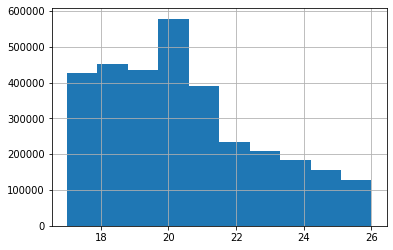

20    578867
18    451260
19    434147
17    426411
21    391831
22    235107
23    210039
24    183319
25    156823
26    128089
Name: dealer_result, dtype: int64

In [13]:
df['dealer_result'].hist(bins=10)
plt.show()
df['dealer_result'].value_counts()

In [6]:
counter =  Counter()

df.apply(
    lambda row: counter.update(
        [(row['dealer_start'], row['dealer_end'])]
    ),
    axis=1
)

0          None
1          None
2          None
3          None
4          None
           ... 
3195888    None
3195889    None
3195890    None
3195891    None
3195892    None
Length: 3195893, dtype: object

In [20]:
sorted(counter.items(), key=lambda x: -x[1])[:5]

[((10, 20), 333511),
 ((10, 22), 209727),
 ((10, 21), 110749),
 ((10, 17), 110378),
 ((10, 19), 110306)]

In [10]:
sum(counter.values()) == len(df)

True

In [30]:
probs = {
    key: counter[key] * 1.0 / len(df)
    for key in counter
}

conditional_probs = {
    (start_key, end_key): counter[(start_key, end_key)] * 1.0 / sum([
        counter[(start_key, ndx)] for ndx in range(17, 23)
    ])
    for start_key, end_key in counter
}

In [31]:
# Reality Check
for ndx in range(1, 11):
    print(f"{ndx}: {sum([conditional_probs[(ndx, val)] for val in range(17, 23)])}")

1: 0.9999999999999999
2: 1.0
3: 1.0
4: 1.0
5: 1.0
6: 1.0
7: 1.0
8: 0.9999999999999999
9: 1.0
10: 1.0


In [33]:
sorted(conditional_probs.items(), key=lambda x: -x[1])

[((6, 22), 0.43901833802496054),
 ((5, 22), 0.41902860349553095),
 ((4, 22), 0.3956475842468534),
 ((3, 22), 0.3776412426504995),
 ((1, 21), 0.37367831769232335),
 ((7, 17), 0.36820105906579936),
 ((8, 18), 0.3580723265432779),
 ((2, 22), 0.35756819093868186),
 ((9, 19), 0.3531423354242835),
 ((10, 20), 0.3386689277699361),
 ((7, 22), 0.260496682247573),
 ((8, 22), 0.24626710273276253),
 ((9, 22), 0.22856572227452995),
 ((10, 22), 0.21297054134467946),
 ((1, 19), 0.14342365083565742),
 ((1, 18), 0.14326893715774688),
 ((1, 20), 0.14272743928505996),
 ((7, 18), 0.14057137253620108),
 ((1, 22), 0.13869266942165584),
 ((2, 18), 0.13609407491781417),
 ((2, 19), 0.13208916200845572),
 ((3, 18), 0.13103574552926575),
 ((8, 17), 0.1299378973284827),
 ((2, 17), 0.1290084597704877),
 ((8, 19), 0.127149197483229),
 ((3, 19), 0.12697495575041198),
 ((4, 18), 0.1265692245229395),
 ((3, 17), 0.12619372164466056),
 ((2, 20), 0.1256885977535195),
 ((5, 18), 0.12330326862236392),
 ((4, 17), 0.12280552

In [38]:
with open('data/tmp/dealer_result_probs.pkl', 'wb') as tmp_file:
    pickle.dump(probs, tmp_file)
with open('data/tmp/dealer_result_conditional_probs.pkl', 'wb') as tmp_file:
    pickle.dump(conditional_probs, tmp_file)

## Save and Load

In [44]:
df.to_csv('data/tmp/dealer_expectation_output_100000_chutes.csv.csv', index=False)

In [5]:
df = pd.read_csv('data/tmp/dealer_expectation_output_100000_chutes.csv')

#### Reformatting Counter dicts to DF

In [10]:
with open('data/tmp/dealer_result_conditional_probs.pkl', 'rb') as tmp_file:
    cond_probs = pickle.load(tmp_file)

cond_data = {
    'start_card': [],
    'end_val': [],
    'cond_prob': []
}

for (start_card, end_val), prob in cond_probs.items():
    cond_data['start_card'].append(start_card)
    cond_data['end_val'].append(end_val)
    cond_data['cond_prob'].append(prob)

cond_df = pd.DataFrame(cond_data)

In [11]:
cond_df

,start_card,end_val,cond_prob
0,10,21,0.112462
1,10,22,0.212971
2,4,22,0.395648
3,7,17,0.368201
4,4,17,0.122806
5,8,22,0.246267
6,4,21,0.114214
7,10,20,0.338669
8,9,19,0.353142
9,2,20,0.125689
